# ANÁLISIS DE CLUSTERING PARA IDENTIFICACIÓN DE PERFILES DE POBREZA MULTIDIMENSIONAL
## Encuesta de Calidad de Vida 2024 - Colombia

### Objetivos:
1. Identificar perfiles diferenciados de hogares según sus privaciones
2. Validar la consistencia de los clusters con el IPM oficial
3. Caracterizar territorialmente los grupos identificados
4. Generar insumos para políticas públicas focalizadas

In [ ]:
# 1. CONFIGURACIÓN INICIAL Y LIBRERÍAS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# Librerías de clustering
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
    silhouette_samples
)

print("="*80)
print("ANÁLISIS DE CLUSTERING PARA PERFILES DE POBREZA MULTIDIMENSIONAL")
print("="*80)

ANÁLISIS DE CLUSTERING PARA PERFILES DE POBREZA MULTIDIMENSIONAL


In [ ]:
# 2. CARGA DE DATOS

df = pd.read_csv("hogares_ML.csv")
print(f"Dimensiones del dataset: {df.shape}")
print(f"Hogares totales: {df.shape[0]:,}")
print(f"Variables disponibles: {df.shape[1]}")

# Verificar variables críticas
variables_criticas = ['POBRE', 'IPM', 'CLASE', 'DEPARTAMENTO', 'FEX_C']
for var in variables_criticas:
    if var in df.columns:
        print(f"✓ {var} presente")
    else:
        print(f"✗ {var} NO encontrada")

Dimensiones del dataset: (53103, 30)
Hogares totales: 53,103
Variables disponibles: 30
✓ POBRE presente
✓ IPM presente
✓ CLASE presente
✓ DEPARTAMENTO presente
✓ FEX_C presente


In [ ]:
# 3. SELECCIÓN DE VARIABLES

# Variables de privación del IPM
vars_privaciones = [
    # Educación
    "LOGRO_2", "ALFA_2", "ASISTE_2", "REZAGO_2", "A_INTEGRAL_2",
    # Trabajo
    "TRABAJOINF_2", "DES_DURA_2", "EFORMAL_2",
    # Salud
    "SEGURO_SALUD_2", "SALUD_NEC_2",
    # Vivienda
    "ACUEDUCTO", "ALCANTARILLADO", "PISOS", "PAREDES", "HACINAMIENTO"
]

# Variables del hogar
vars_hogar = []
vars_hogar_candidatas = ["JEF_MUJER", "EDAD_JEF", "TAM_HOG", "MENORES", "MAYORES", "OCUPADOS"]
for var in vars_hogar_candidatas:
    if var in df.columns:
        vars_hogar.append(var)

# CRÍTICO: Variables territoriales
if 'CLASE' in df.columns:
    df['ZONA_RURAL'] = (df['CLASE'] == 3).astype(int)
    df['ZONA_CENTRO_POBLADO'] = (df['CLASE'] == 2).astype(int)
    vars_territoriales = ['ZONA_RURAL', 'ZONA_CENTRO_POBLADO']
else:
    vars_territoriales = []

# Verificar disponibilidad
vars_disponibles = [v for v in vars_privaciones if v in df.columns]
feature_cols = vars_disponibles + vars_hogar + vars_territoriales

print(f"Variables de privación: {len(vars_disponibles)}/15")
print(f"Variables del hogar: {len(vars_hogar)}")
print(f"Variables territoriales: {len(vars_territoriales)}")
print(f"\nTotal para clustering: {len(feature_cols)}")

X = df[feature_cols].copy()

Variables de privación: 15/15
Variables del hogar: 0
Variables territoriales: 2

Total para clustering: 17


Top 10 variables más correlacionadas con IPM:


,Variable,Corr_IPM
0,LOGRO_2,0.702765
1,ALFA_2,0.541045
12,PISOS,0.388710
10,ACUEDUCTO,0.383941
11,ALCANTARILLADO,0.362847
6,DES_DURA_2,0.294973
3,REZAGO_2,0.292683
15,ZONA_RURAL,0.279633
2,ASISTE_2,0.240678
8,SEGURO_SALUD_2,0.226868


<Figure size 1000x600 with 0 Axes>

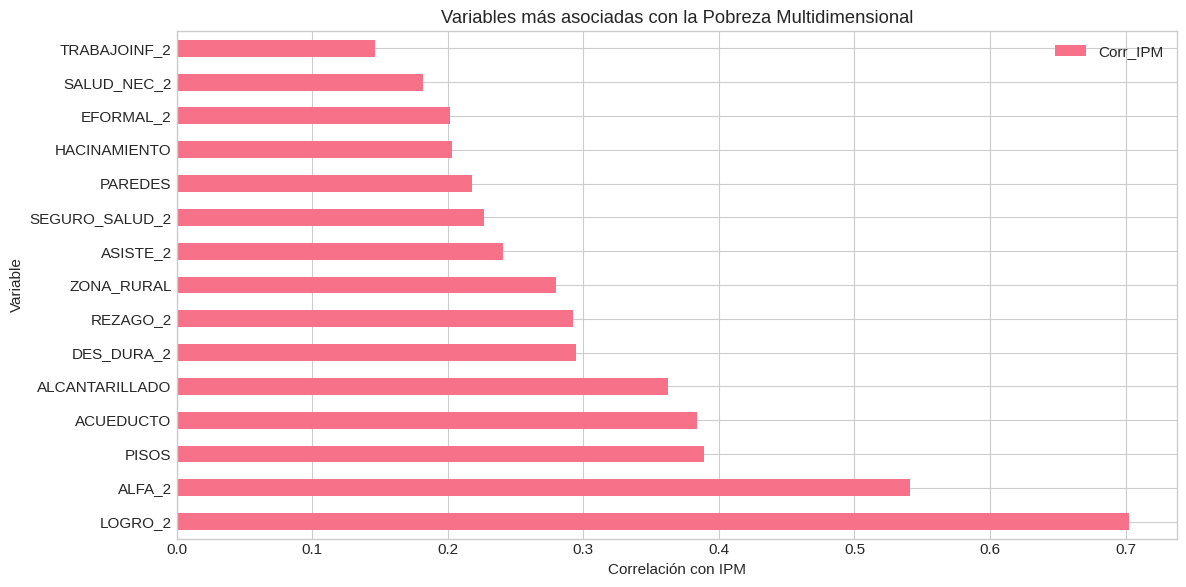

In [ ]:
# 4. ANÁLISIS EXPLORATORIO

# Correlación con IPM
if 'IPM' in df.columns:
    correlations = pd.DataFrame({
        'Variable': feature_cols,
        'Corr_IPM': [df['IPM'].corr(X[col]) for col in feature_cols]
    }).sort_values('Corr_IPM', ascending=False)

    print("Top 10 variables más correlacionadas con IPM:")
    display(correlations.head(10))

    # Visualización
    plt.figure(figsize=(10, 6))
    correlations.head(15).plot(x='Variable', y='Corr_IPM', kind='barh')
    plt.xlabel('Correlación con IPM')
    plt.title('Variables más asociadas con la Pobreza Multidimensional')
    plt.tight_layout()
    plt.show()

In [ ]:
# 5. PREPROCESAMIENTO Y ESCALADO

# Identificar tipos de variables
binary_cols = [col for col in feature_cols if X[col].nunique() == 2]
continuous_cols = [col for col in feature_cols if col not in binary_cols]

print(f"Variables binarias: {len(binary_cols)}")
print(f"Variables continuas: {len(continuous_cols)}")

X_scaled = X.copy()

# Escalar solo las continuas (si existen)
if len(continuous_cols) > 0:
    scaler = RobustScaler()  # Robusto a outliers
    X_scaled[continuous_cols] = scaler.fit_transform(X[continuous_cols])
    print("✓ Variables continuas escaladas")

X_scaled = X_scaled.values
print(f"\nMatriz de características: {X_scaled.shape}")

Variables binarias: 17
Variables continuas: 0

Matriz de características: (53103, 17)


In [ ]:
# 6. DETERMINACIÓN DEL NÚMERO ÓPTIMO DE CLUSTERS

range_clusters = range(2, 11)
metrics = {
    'inertia': [],
    'silhouette': [],
    'calinski': [],
    'davies': []
}

print("Evaluando diferentes números de clusters...")
for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)

    metrics['inertia'].append(kmeans.inertia_)
    metrics['silhouette'].append(silhouette_score(X_scaled, labels))
    metrics['calinski'].append(calinski_harabasz_score(X_scaled, labels))
    metrics['davies'].append(davies_bouldin_score(X_scaled, labels))

    print(f"k={k}: Silhouette={metrics['silhouette'][-1]:.3f}, "
          f"Davies-Bouldin={metrics['davies'][-1]:.3f}")

Evaluando diferentes números de clusters...


KeyboardInterrupt: 

In [ ]:
# 7. VISUALIZACIÓN DE MÉTRICAS

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Elbow
axes[0,0].plot(range_clusters, metrics['inertia'], 'bo-')
axes[0,0].set_xlabel('Número de Clusters')
axes[0,0].set_ylabel('Inercia')
axes[0,0].set_title('Método del Codo')
axes[0,0].grid(True, alpha=0.3)

# Silhouette
axes[0,1].plot(range_clusters, metrics['silhouette'], 'go-')
axes[0,1].set_xlabel('Número de Clusters')
axes[0,1].set_ylabel('Coeficiente de Silhouette')
axes[0,1].set_title('Análisis de Silhouette (mayor es mejor)')
axes[0,1].axhline(y=0.5, color='r', linestyle='--', alpha=0.5)
axes[0,1].grid(True, alpha=0.3)

# Calinski
axes[1,0].plot(range_clusters, metrics['calinski'], 'ro-')
axes[1,0].set_xlabel('Número de Clusters')
axes[1,0].set_ylabel('Índice Calinski-Harabasz')
axes[1,0].set_title('Índice Calinski-Harabasz (mayor es mejor)')
axes[1,0].grid(True, alpha=0.3)

# Davies-Bouldin
axes[1,1].plot(range_clusters, metrics['davies'], 'mo-')
axes[1,1].set_xlabel('Número de Clusters')
axes[1,1].set_ylabel('Índice Davies-Bouldin')
axes[1,1].set_title('Índice Davies-Bouldin (menor es mejor)')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Determinación automática
optimal_k_sil = range_clusters[np.argmax(metrics['silhouette'])]
optimal_k_db = range_clusters[np.argmin(metrics['davies'])]
print(f"\nÓptimo según Silhouette: {optimal_k_sil}")
print(f"Óptimo según Davies-Bouldin: {optimal_k_db}")

In [ ]:
# 8. CLUSTERING FINAL

# Seleccionar número de clusters (ajustar según resultados anteriores)
n_clusters_final = 10  # Modificar según análisis

print(f"Aplicando K-Means con {n_clusters_final} clusters...")

kmeans_final = KMeans(
    n_clusters=n_clusters_final,
    random_state=42,
    n_init=50,  # Más inicializaciones para estabilidad
    max_iter=500
)

cluster_labels = kmeans_final.fit_predict(X_scaled)
df['CLUSTER'] = cluster_labels

# Métricas finales
sil_score = silhouette_score(X_scaled, cluster_labels)
cal_score = calinski_harabasz_score(X_scaled, cluster_labels)
dav_score = davies_bouldin_score(X_scaled, cluster_labels)

print(f"\nMétricas del clustering final:")
print(f"  Silhouette Score: {sil_score:.3f}")
print(f"  Calinski-Harabasz: {cal_score:.1f}")
print(f"  Davies-Bouldin: {dav_score:.3f}")

Aplicando K-Means con 10 clusters...

Métricas del clustering final:
  Silhouette Score: 0.289
  Calinski-Harabasz: 6134.6
  Davies-Bouldin: 1.563


In [ ]:
# 9. VALIDACIÓN DE ESTABILIDAD

n_iterations = 10
stability_scores = []

for i in range(n_iterations):
    # Submuestreo 80%
    idx = np.random.choice(len(X_scaled), size=int(0.8*len(X_scaled)), replace=False)
    X_sample = X_scaled[idx]

    kmeans_temp = KMeans(n_clusters=n_clusters_final, random_state=i, n_init=10)
    labels_temp = kmeans_temp.fit_predict(X_sample)

    sil_temp = silhouette_score(X_sample, labels_temp)
    stability_scores.append(sil_temp)

print(f"Estabilidad del clustering (n={n_iterations}):")
print(f"  Silhouette promedio: {np.mean(stability_scores):.3f}")
print(f"  Desviación estándar: {np.std(stability_scores):.3f}")
print(f"  CV: {np.std(stability_scores)/np.mean(stability_scores):.3f}")

Estabilidad del clustering (n=10):
  Silhouette promedio: 0.293
  Desviación estándar: 0.010
  CV: 0.033


In [ ]:
# 10. CARACTERIZACIÓN DE CLUSTERS

for cluster_id in range(n_clusters_final):
    cluster_data = df[df['CLUSTER'] == cluster_id]
    n_cluster = len(cluster_data)

    print(f"\n{'='*50}")
    print(f"CLUSTER {cluster_id}")
    print(f"{'='*50}")
    print(f"Tamaño: {n_cluster:,} hogares ({100*n_cluster/len(df):.1f}%)")

    # Población expandida si existe FEX_C
    if 'FEX_C' in df.columns:
        pop_exp = cluster_data['FEX_C'].sum()
        pop_total = df['FEX_C'].sum()
        print(f"Población expandida: {pop_exp:,.0f} ({100*pop_exp/pop_total:.1f}%)")

    # Tasa de pobreza
    if 'POBRE' in df.columns:
        tasa_pobreza = cluster_data['POBRE'].mean() * 100
        print(f"Tasa de pobreza: {tasa_pobreza:.1f}%")

    # IPM promedio
    if 'IPM' in df.columns:
        print(f"IPM promedio: {cluster_data['IPM'].mean():.3f} (σ={cluster_data['IPM'].std():.3f})")

    # Distribución por zona
    if 'CLASE' in df.columns:
        zona_dist = cluster_data['CLASE'].value_counts(normalize=True) * 100
        zona_nombres = {1: 'Cabecera', 2: 'Centro Poblado', 3: 'Rural Disperso'}
        print("\nDistribución por zona:")
        for zona, pct in zona_dist.items():
            print(f"  {zona_nombres.get(zona)}: {pct:.1f}%")

    # Top privaciones
    print("\nTop 5 privaciones:")
    privaciones = cluster_data[vars_disponibles].mean().sort_values(ascending=False).head(5)
    for priv, val in privaciones.items():
        print(f"  {priv}: {val*100:.1f}%")


CLUSTER 0
Tamaño: 14,753 hogares (27.8%)
Población expandida: 4,813,359 (40.5%)
Tasa de pobreza: 0.1%
IPM promedio: 0.113 (σ=0.039)

Distribución por zona:
  Cabecera: 76.1%
  Rural Disperso: 12.0%
  Centro Poblado: 11.9%

Top 5 privaciones:
  EFORMAL_2: 96.9%
  A_INTEGRAL_2: 6.2%
  SEGURO_SALUD_2: 5.5%
  HACINAMIENTO: 4.6%
  SALUD_NEC_2: 2.7%

CLUSTER 1
Tamaño: 5,485 hogares (10.3%)
Población expandida: 1,830,839 (15.4%)
Tasa de pobreza: 11.7%
IPM promedio: 0.217 (σ=0.084)

Distribución por zona:
  Cabecera: 82.6%
  Centro Poblado: 9.7%
  Rural Disperso: 7.7%

Top 5 privaciones:
  REZAGO_2: 100.0%
  EFORMAL_2: 97.1%
  LOGRO_2: 34.7%
  HACINAMIENTO: 11.8%
  SEGURO_SALUD_2: 7.1%

CLUSTER 2
Tamaño: 5,289 hogares (10.0%)
Población expandida: 491,625 (4.1%)
Tasa de pobreza: 29.4%
IPM promedio: 0.282 (σ=0.084)

Distribución por zona:
  Rural Disperso: 100.0%
  Cabecera: 0.0%

Top 5 privaciones:
  ACUEDUCTO: 100.0%
  EFORMAL_2: 99.4%
  LOGRO_2: 80.7%
  REZAGO_2: 21.7%
  ALCANTARILLADO: 16.5

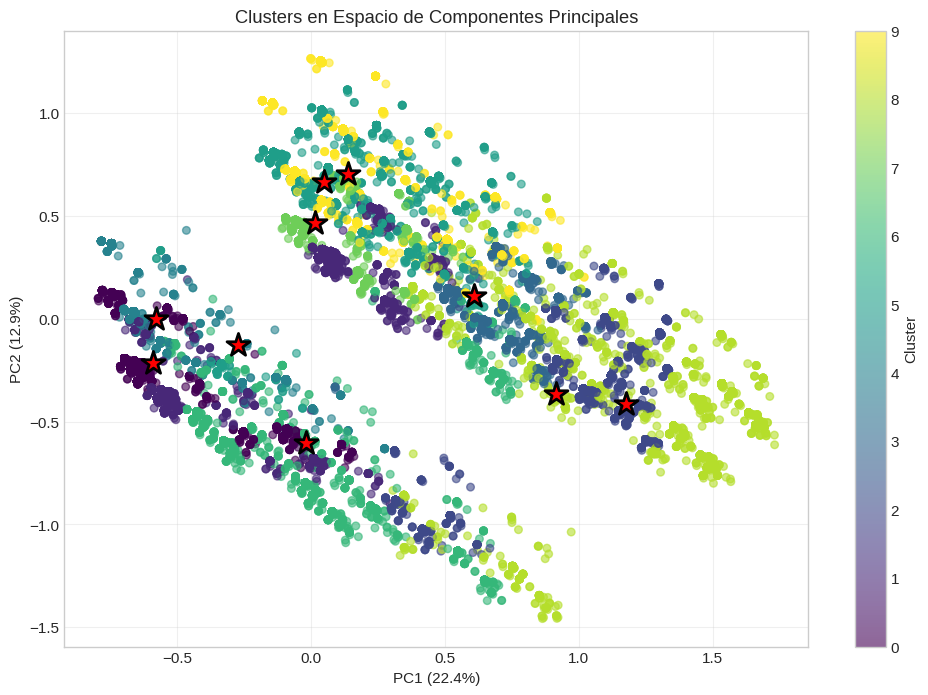

In [ ]:
# 11. VISUALIZACIÓN PCA

# Reducción de dimensionalidad
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1],
                     c=cluster_labels,
                     cmap='viridis',
                     alpha=0.6, s=30)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.title('Clusters en Espacio de Componentes Principales')
plt.colorbar(scatter, label='Cluster')

# Centroides
centroids_pca = pca.transform(kmeans_final.cluster_centers_)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1],
           marker='*', s=300, c='red', edgecolor='black', linewidth=2)

plt.grid(True, alpha=0.3)
plt.show()

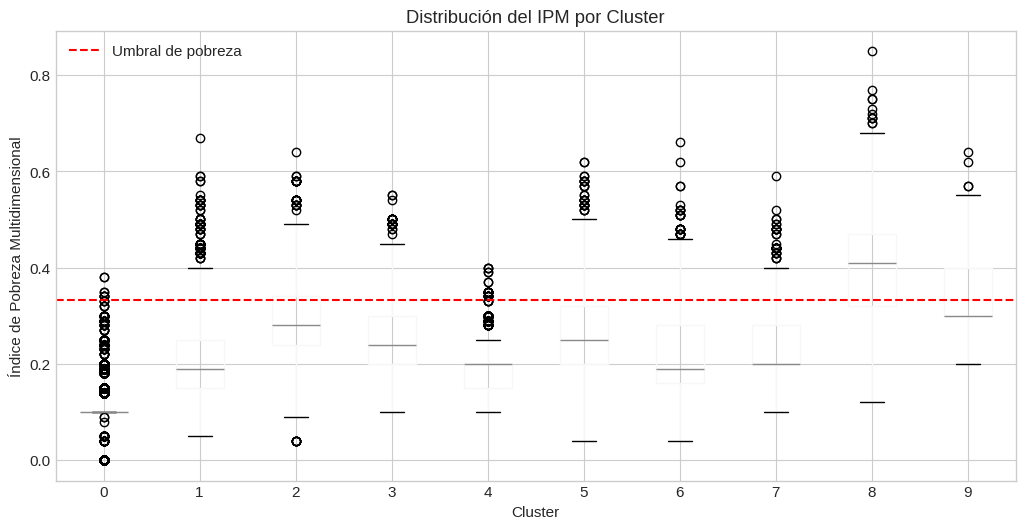


Estadísticas del IPM por cluster:
           count      mean       std   min   25%   50%   75%   max
CLUSTER                                                           
0        14753.0  0.112813  0.038795  0.00  0.10  0.10  0.10  0.38
1         5485.0  0.216890  0.083728  0.05  0.15  0.19  0.25  0.67
2         5289.0  0.282099  0.083828  0.04  0.24  0.28  0.34  0.64
3         5452.0  0.250734  0.061579  0.10  0.20  0.24  0.30  0.55
4         2584.0  0.190472  0.059312  0.10  0.15  0.20  0.20  0.40
5         4248.0  0.269576  0.080785  0.04  0.20  0.25  0.32  0.62
6         3325.0  0.220568  0.079908  0.04  0.16  0.19  0.28  0.66
7         5757.0  0.235854  0.054596  0.10  0.20  0.20  0.28  0.59
8         2375.0  0.403836  0.096510  0.12  0.32  0.41  0.47  0.85
9         3835.0  0.330399  0.065755  0.20  0.30  0.30  0.40  0.64


In [ ]:
# 12. DISTRIBUCIÓN IPM POR CLUSTER

if 'IPM' in df.columns:
    plt.figure(figsize=(12, 6))

    # Boxplot
    df.boxplot(column='IPM', by='CLUSTER', ax=plt.gca())
    plt.xlabel('Cluster')
    plt.ylabel('Índice de Pobreza Multidimensional')
    plt.title('Distribución del IPM por Cluster')
    plt.suptitle('')

    # Línea de pobreza
    plt.axhline(y=0.333, color='r', linestyle='--', label='Umbral de pobreza')
    plt.legend()
    plt.show()

    # Estadísticas
    print("\nEstadísticas del IPM por cluster:")
    print(df.groupby('CLUSTER')['IPM'].describe())

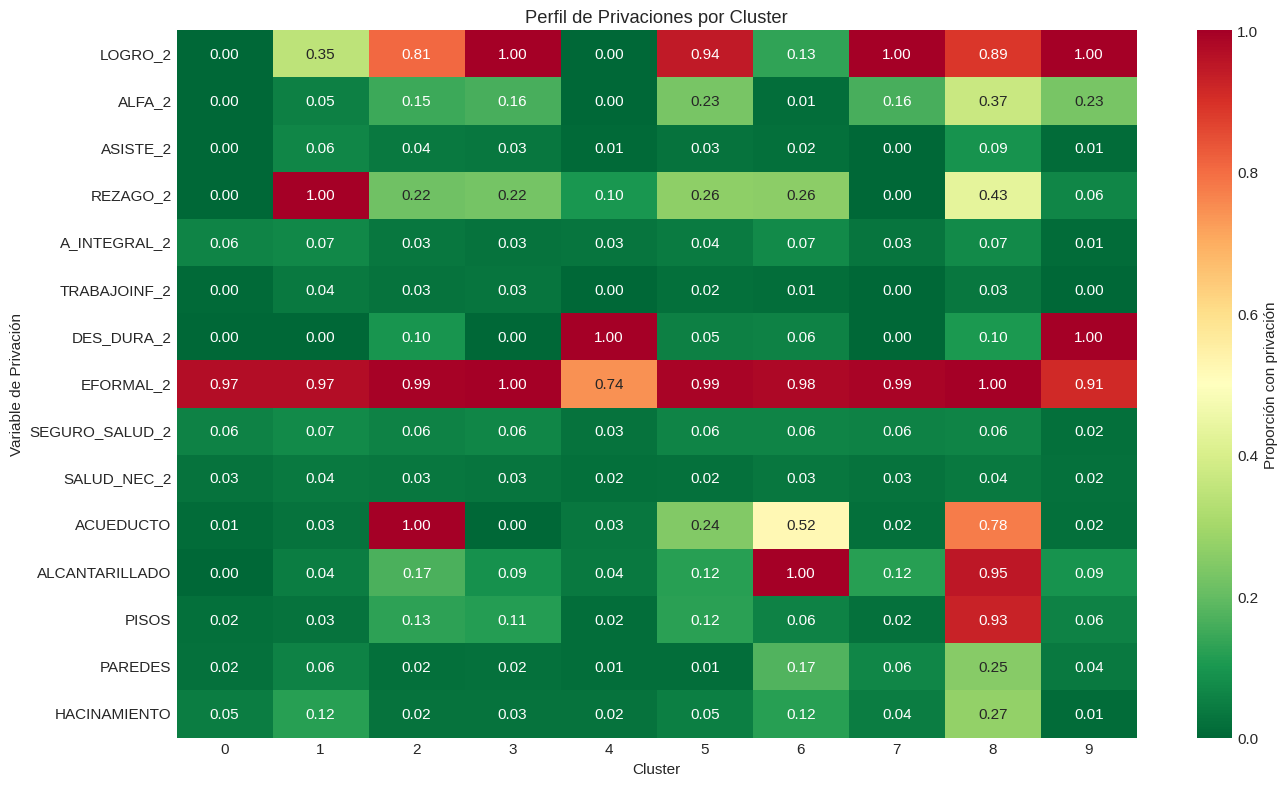

In [ ]:
# 13. HEATMAP DE PRIVACIONES POR CLUSTER

cluster_means = df.groupby('CLUSTER')[vars_disponibles].mean()

plt.figure(figsize=(14, 8))
sns.heatmap(cluster_means.T, annot=True, fmt='.2f',
            cmap='RdYlGn_r', vmin=0, vmax=1,
            cbar_kws={'label': 'Proporción con privación'})
plt.xlabel('Cluster')
plt.ylabel('Variable de Privación')
plt.title('Perfil de Privaciones por Cluster')
plt.tight_layout()
plt.show()

In [ ]:
!pip install umap-learn


✓ Figura guardada: mapa1_umap_knn_clusters_mejorado.png


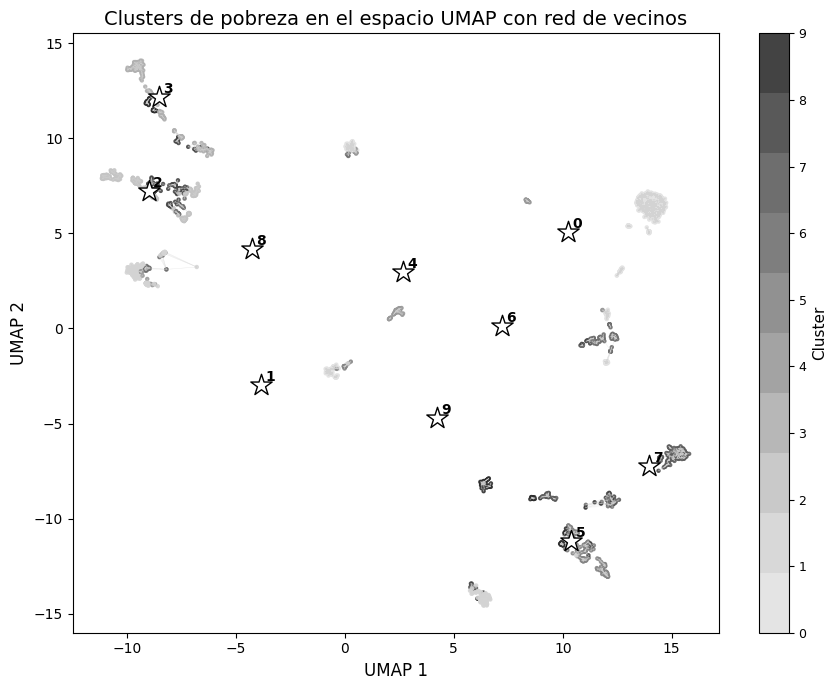

In [ ]:
# ============================================================
# MAPA 1 (MEJORADO):
# UMAP + red de vecinos cercanos entre hogares (estilo tesis)
# ============================================================

import umap
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.neighbors import NearestNeighbors

plt.style.use("default")

# ------------------------------------------------------------
# 1. Submuestra para que el gráfico sea legible
# ------------------------------------------------------------
n_muestra = 4000
if X_scaled.shape[0] > n_muestra:
    idx_muestra = np.random.choice(X_scaled.shape[0], size=n_muestra, replace=False)
else:
    idx_muestra = np.arange(X_scaled.shape[0])

X_scaled_sub = X_scaled[idx_muestra]
clusters_sub = cluster_labels[idx_muestra]

# ------------------------------------------------------------
# 2. Embedding UMAP en 2D
# ------------------------------------------------------------
umap_2d = umap.UMAP(
    n_neighbors=30,
    min_dist=0.1,
    n_components=2,
    random_state=42
)

X_umap = umap_2d.fit_transform(X_scaled_sub)

# ------------------------------------------------------------
# 3. Construir grafo k-NN (en el espacio UMAP)
# ------------------------------------------------------------
k = 8  # número de vecinos por nodo
nbrs = NearestNeighbors(n_neighbors=k + 1).fit(X_umap)
distancias, indices = nbrs.kneighbors(X_umap)

# ------------------------------------------------------------
# 4. Paleta en escala de grises para clusters
# ------------------------------------------------------------
unique_clusters = np.unique(clusters_sub)
n_clusters = unique_clusters.size

# Tonos de gris desde oscuro (pobreza alta) a claro (pobreza baja) si luego quieres dar sentido
greys = plt.cm.Greys(np.linspace(0.20, 0.85, n_clusters))
cluster_cmap = ListedColormap(greys)

# ------------------------------------------------------------
# 5. Gráfico
# ------------------------------------------------------------
fig, ax = plt.subplots(figsize=(9, 7))

# 5a. Red de vecinos (líneas muy finas y discretas)
for i in range(X_umap.shape[0]):
    for j in indices[i, 1:]:  # saltar el primer vecino (es el propio punto)
        x_coords = [X_umap[i, 0], X_umap[j, 0]]
        y_coords = [X_umap[i, 1], X_umap[j, 1]]
        ax.plot(
            x_coords, y_coords,
            color="lightgray",
            linewidth=0.25,
            alpha=0.3
        )

# 5b. Nodos (hogares), coloreados por cluster en escala de grises
scatter = ax.scatter(
    X_umap[:, 0],
    X_umap[:, 1],
    c=clusters_sub,
    cmap=cluster_cmap,
    s=10,
    alpha=0.9,
    edgecolors="none"
)

# 5c. Centroides de cada cluster (estrellas blancas borde negro)
for k_cl in unique_clusters:
    mask = clusters_sub == k_cl
    centroid = X_umap[mask].mean(axis=0)
    ax.scatter(
        centroid[0],
        centroid[1],
        marker="*",
        s=260,
        edgecolor="black",
        facecolor="white",
        linewidths=1.0,
        zorder=5
    )
    ax.text(
        centroid[0] + 0.2,
        centroid[1] + 0.2,
        str(k_cl),
        fontsize=10,
        weight="bold"
    )

# ------------------------------------------------------------
# 6. Estética tipo tesis
# ------------------------------------------------------------
ax.set_title(
    "Clusters de pobreza en el espacio UMAP con red de vecinos",
    fontsize=14
)
ax.set_xlabel("UMAP 1", fontsize=12)
ax.set_ylabel("UMAP 2", fontsize=12)

# Fondo blanco y sin cuadrícula
ax.set_facecolor("white")
ax.grid(False)

# Colorbar discreta para clusters
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label("Cluster", fontsize=11)
cbar.ax.tick_params(labelsize=9)

fig.tight_layout()
fig.savefig("mapa1_umap_knn_clusters_mejorado.png", dpi=300, bbox_inches="tight")
print("✓ Figura guardada: mapa1_umap_knn_clusters_mejorado.png")

plt.show()
plt.close(fig)



In [ ]:
# ============================================================
# DEFINICIÓN DE VARIABLES DE PRIVACIÓN (IPM ECV 2024)
# ============================================================

privaciones_cols = [
    "LOGRO_2",        # Logro educativo
    "ALFA_2",         # Alfabetismo
    "ASISTE_2",       # Asistencia escolar
    "REZAGO_2",       # Rezago escolar
    "A_INTEGRAL_2",   # Aseguramiento integral
    "TRABAJOINF_2",   # Trabajo infantil
    "DES_DURA_2",     # Desempleo de larga duración
    "EFORMAL_2",      # Empleo informal
    "SEGURO_SALUD_2", # Afiliación a salud
    "SALUD_NEC_2",    # Necesidad de salud no atendida
    "ACUEDUCTO",      # Sin acueducto
    "ALCANTARILLADO", # Sin alcantarillado
    "PISOS",          # Material piso inadecuado
    "PAREDES",        # Material pared inadecuado
    "HACINAMIENTO"    # Hacinamiento crítico
]

# Validar columnas existentes
missing = [c for c in privaciones_cols if c not in df.columns]
print("Columnas faltantes:", missing)


Columnas faltantes: []


In [ ]:
# ============================================================
# INSUMOS PARA EL MAPA 2 (Red entre clusters)
# ============================================================

# Matriz binaria de privaciones 0/1
X_priv = df[privaciones_cols].values

# Vector de clusters (asegúrate que ya lo tengas definido)
clusters = cluster_labels  # o df["cluster"] si así lo guardaste

# Número de clusters finales
K = len(np.unique(clusters))

print("X_priv shape:", X_priv.shape)
print("Clusters únicos:", np.unique(clusters))


X_priv shape: (53103, 15)
Clusters únicos: [0 1 2 3 4 5 6 7 8 9]


✓ Figura guardada: mapa2_red_clusters.png


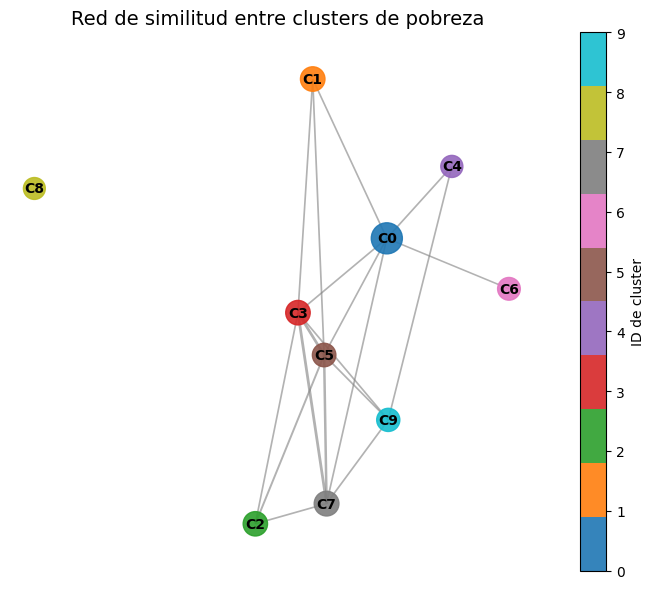

In [ ]:
# ============================================================
# MAPA 2: Red entre clusters (macro-grafo)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

plt.style.use("default")

# 1. Construir una matriz con las variables de privación y el cluster
X_priv = df[privaciones_cols].values  # 0/1 por privación
clusters = cluster_labels

k_unicos = np.unique(clusters)

# 2. Centroides de cada cluster en el espacio de privaciones
centroides = {}
tam_clusters = {}
for k_cl in k_unicos:
    mask = clusters == k_cl
    centroides[k_cl] = X_priv[mask].mean(axis=0)
    tam_clusters[k_cl] = mask.sum()

# 3. Matriz de distancias entre centroides (euclidianas)
K = len(k_unicos)
dist_matrix = np.zeros((K, K))
for i, ki in enumerate(k_unicos):
    for j, kj in enumerate(k_unicos):
        if i < j:
            d = np.linalg.norm(centroides[ki] - centroides[kj])
            dist_matrix[i, j] = dist_matrix[j, i] = d

# 4. Convertir distancia en "similitud" para grafo (inversa)
#    y aplicar un umbral para no dibujar todas las aristas
sim_matrix = 1 / (1 + dist_matrix)  # más grande = más similares
umbral_sim = np.quantile(sim_matrix[np.triu_indices(K, k=1)], 0.6)  # top 40% similitud

# 5. Construir grafo
G = nx.Graph()
for i, ki in enumerate(k_unicos):
    G.add_node(
        int(ki),
        size=tam_clusters[ki]
    )

for i, ki in enumerate(k_unicos):
    for j, kj in enumerate(k_unicos):
        if i < j:
            sim = sim_matrix[i, j]
            if sim >= umbral_sim:
                G.add_edge(int(ki), int(kj), weight=sim)

# 6. Layout del grafo (spring)
pos = nx.spring_layout(G, seed=42, weight="weight", k=0.5)

# 7. Dibujar
fig, ax = plt.subplots(figsize=(7, 6))

# tamaños de nodos proporcionales al tamaño del cluster
sizes = np.array([G.nodes[n]["size"] for n in G.nodes()])
sizes_plot = 300 * (sizes / sizes.max()) + 200  # escala visual

# ancho de aristas según peso
weights = np.array([G[u][v]["weight"] for u, v in G.edges()])
widths_plot = 2 * (weights / weights.max())

nx.draw_networkx_edges(G, pos, ax=ax, width=widths_plot, alpha=0.6, edge_color="gray")
nodes = nx.draw_networkx_nodes(
    G, pos, ax=ax,
    node_size=sizes_plot,
    node_color=list(G.nodes()),
    cmap="tab10",
    alpha=0.9
)
nx.draw_networkx_labels(G, pos, ax=ax, labels={n: f"C{n}" for n in G.nodes()},
                        font_size=10, font_weight="bold")

ax.set_title("Red de similitud entre clusters de pobreza", fontsize=14)
ax.axis("off")

fig.colorbar(nodes, ax=ax, label="ID de cluster")
fig.tight_layout()
fig.savefig("mapa2_red_clusters.png", dpi=300, bbox_inches="tight")
print("✓ Figura guardada: mapa2_red_clusters.png")

plt.show()
plt.close(fig)


✓ Figura guardada: mapa2_red_clusters_tesis_v2.png


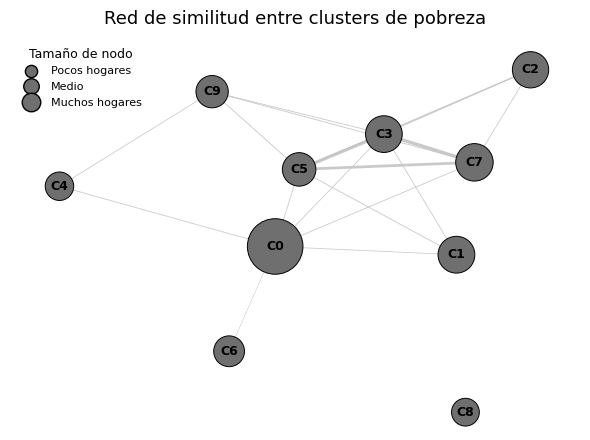

In [ ]:
# ============================================================
# DIBUJO PROFESIONAL DEL GRAFO (usar después de construir G)
# ============================================================

import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.lines import Line2D

# 1. Layout más estable y "bonito": Kamada-Kawai
pos = nx.kamada_kawai_layout(G, weight="weight")

# 2. Tamaños de nodos moderados (sin exagerar)
sizes = np.array([G.nodes[n]["size"] for n in G.nodes()])
sizes_plot = 400 + 1200 * (sizes - sizes.min()) / (sizes.max() - sizes.min() + 1e-9)

# 3. Grosores de aristas según similitud
if G.number_of_edges() > 0:
    weights = np.array([G[u][v]["weight"] for u, v in G.edges()])
    widths_plot = 0.4 + 2.0 * (weights - weights.min()) / (weights.max() - weights.min() + 1e-9)
else:
    widths_plot = []

fig, ax = plt.subplots(figsize=(6, 4.5))

# 4. Aristas en gris claro
nx.draw_networkx_edges(
    G, pos, ax=ax,
    width=widths_plot,
    edge_color="#c4c4c4",
    alpha=0.9
)

# 5. Nodos en gris medio, borde negro
nx.draw_networkx_nodes(
    G, pos, ax=ax,
    node_size=sizes_plot,
    node_color="#6f6f6f",
    edgecolors="black",
    linewidths=0.7
)

# 6. Etiquetas C0, C1… en negro, sin cajas raras
nx.draw_networkx_labels(
    G, pos, ax=ax,
    labels={n: f"C{n}" for n in G.nodes()},
    font_size=9,
    font_weight="bold"
)

# 7. Leyenda simple para el tamaño del nodo
handles = []
for frac, txt in zip([0.25, 0.6, 1.0], ["Pocos hogares", "Medio", "Muchos hogares"]):
    handles.append(
        Line2D(
            [], [], marker="o", linestyle="",
            markersize=np.sqrt(400 + 1200 * frac) / 3.0,
            markerfacecolor="#6f6f6f",
            markeredgecolor="black",
            label=txt
        )
    )

ax.legend(
    handles=handles,
    loc="upper left",
    frameon=False,
    fontsize=8,
    title="Tamaño de nodo",
    title_fontsize=9
)

ax.set_title("Red de similitud entre clusters de pobreza", fontsize=13, pad=10)
ax.set_axis_off()
fig.tight_layout()

fig.savefig("mapa2_red_clusters_tesis_v2.png", dpi=300, bbox_inches="tight")
print("✓ Figura guardada: mapa2_red_clusters_tesis_v2.png")

plt.show()
plt.close(fig)


✓ Figura guardada: mapa2_red_clusters_tesis_v3.png


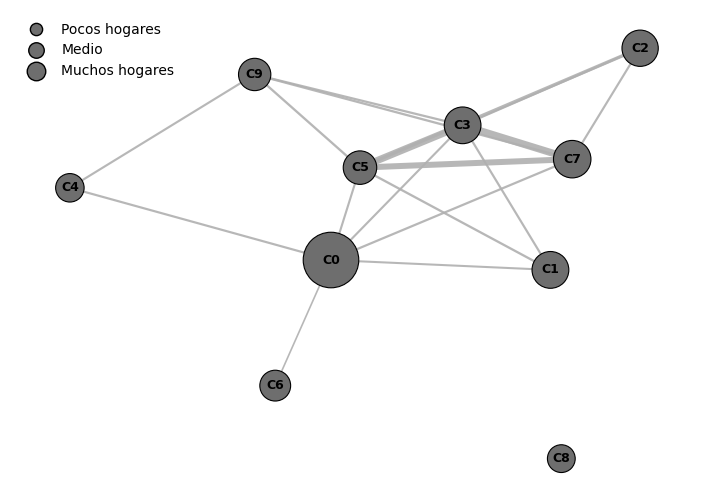

In [ ]:
# ============================================================
# DIBUJO PROFESIONAL DEL GRAFO — VERSIÓN MEJORADA
# ============================================================

import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.lines import Line2D

# 1. Layout más limpio: Kamada-Kawai
pos = nx.kamada_kawai_layout(G, weight="weight")

# 2. Tamaños de nodos
sizes = np.array([G.nodes[n]["size"] for n in G.nodes()])
sizes_plot = 400 + 1200 * (sizes - sizes.min()) / (sizes.max() - sizes.min() + 1e-9)

# 3. Grosores de aristas (más gruesas ahora)
if G.number_of_edges() > 0:
    weights = np.array([G[u][v]["weight"] for u, v in G.edges()])
    widths_plot = 1.2 + 4.0 * (weights - weights.min()) / (weights.max() - weights.min() + 1e-9)
else:
    widths_plot = []

fig, ax = plt.subplots(figsize=(7.2, 5.0))

# 4. Aristas más visibles
nx.draw_networkx_edges(
    G, pos, ax=ax,
    width=widths_plot,
    edge_color="#b0b0b0",
    alpha=0.9
)

# 5. Nodos sobrios en gris medio
nx.draw_networkx_nodes(
    G, pos, ax=ax,
    node_size=sizes_plot,
    node_color="#6e6e6e",
    edgecolors="black",
    linewidths=0.8
)

# 6. Etiquetas (C0, C1…) sin caja, limpias
nx.draw_networkx_labels(
    G, pos, ax=ax,
    labels={n: f"C{n}" for n in G.nodes()},
    font_size=9,
    font_weight="bold"
)

# 7. Nueva leyenda movida a la parte superior derecha
handles = []
for frac, txt in zip([0.25, 0.6, 1.0], ["Pocos hogares", "Medio", "Muchos hogares"]):
    handles.append(
        Line2D(
            [], [], marker="o", linestyle="",
            markersize=np.sqrt(400 + 1200 * frac) / 3.0,
            markerfacecolor="#6e6e6e",
            markeredgecolor="black",
            label=txt
        )
    )

ax.legend(
    handles=handles,
    loc="upper left",      # <<–– ya no está pegado a la izquierda
    frameon=False,
    fontsize=10,
        title_fontsize=9,
)

ax.set_axis_off()
fig.tight_layout()

fig.savefig("mapa2_red_clusters_tesis_v3.png", dpi=300, bbox_inches="tight")
print("✓ Figura guardada: mapa2_red_clusters_tesis_v3.png")

plt.show()
plt.close(fig)


✓ Figura guardada: mapa3_red_privaciones.png


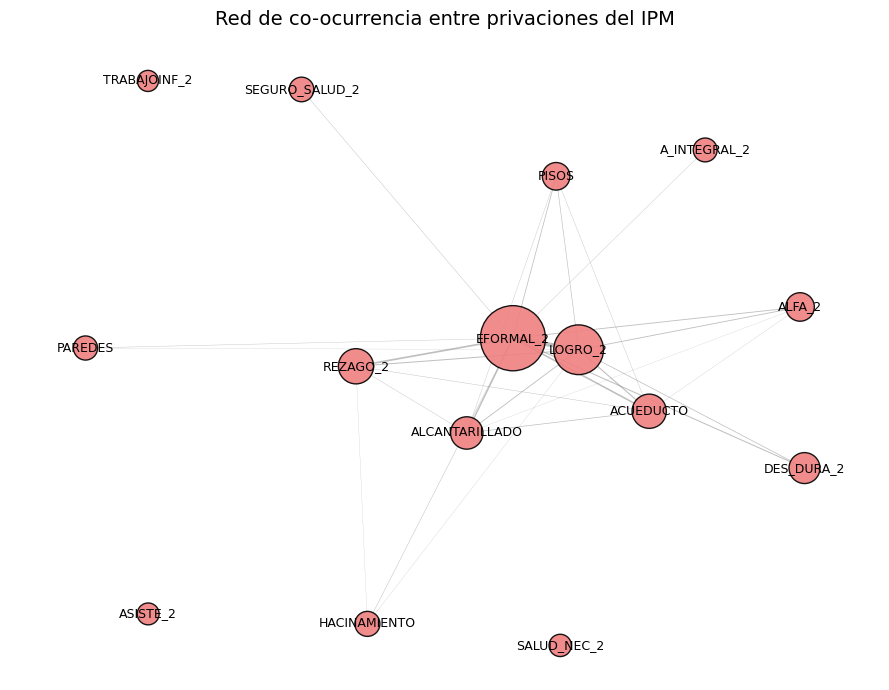

In [ ]:
# ============================================================
# MAPA 3: Red de co-ocurrencia entre privaciones
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

plt.style.use("default")

# 1. Extraer matriz binaria de privaciones
X_priv = df[privaciones_cols].values.astype(float)
n_hogares = X_priv.shape[0]
n_vars = len(privaciones_cols)

# 2. Probabilidad marginal de privación y co-ocurrencia conjunta
p1 = X_priv.mean(axis=0)  # prevalencia de cada privación
cooc = (X_priv.T @ X_priv) / n_hogares  # P(i,j) = proporción de hogares con ambas=1

# 3. Construir grafo: nodos = privaciones, aristas si coocurrencia > umbral
umbral_cooc = np.quantile(cooc[np.triu_indices(n_vars, k=1)], 0.75)  # top 25% co-ocurr.

G = nx.Graph()
for i, var in enumerate(privaciones_cols):
    G.add_node(var, prevalence=p1[i])

for i in range(n_vars):
    for j in range(i + 1, n_vars):
        if cooc[i, j] >= umbral_cooc:
            G.add_edge(privaciones_cols[i], privaciones_cols[j], weight=cooc[i, j])

# 4. Layout (spring)
pos = nx.spring_layout(G, seed=42, weight="weight", k=0.6)

# Tamaño de nodo proporcional a prevalencia
prev = np.array([G.nodes[v]["prevalence"] for v in G.nodes()])
sizes_plot = 2000 * (prev / prev.max()) + 200

# Ancho de arista proporcional a co-ocurrencia
weights = np.array([G[u][v]["weight"] for u, v in G.edges()])
widths_plot = 3 * (weights / weights.max())

# 5. Dibujar
fig, ax = plt.subplots(figsize=(9, 7))

nx.draw_networkx_edges(G, pos, ax=ax, width=widths_plot, alpha=0.5, edge_color="gray")
nx.draw_networkx_nodes(
    G, pos, ax=ax,
    node_size=sizes_plot,
    node_color="lightcoral",
    edgecolors="black",
    alpha=0.9
)
nx.draw_networkx_labels(G, pos, ax=ax, font_size=9)

ax.set_title("Red de co-ocurrencia entre privaciones del IPM", fontsize=14)
ax.axis("off")

fig.tight_layout()
fig.savefig("mapa3_red_privaciones.png", dpi=300, bbox_inches="tight")
print("✓ Figura guardada: mapa3_red_privaciones.png")

plt.show()
plt.close(fig)


✓ Figura guardada: mapa3_red_privaciones_oscuras.png


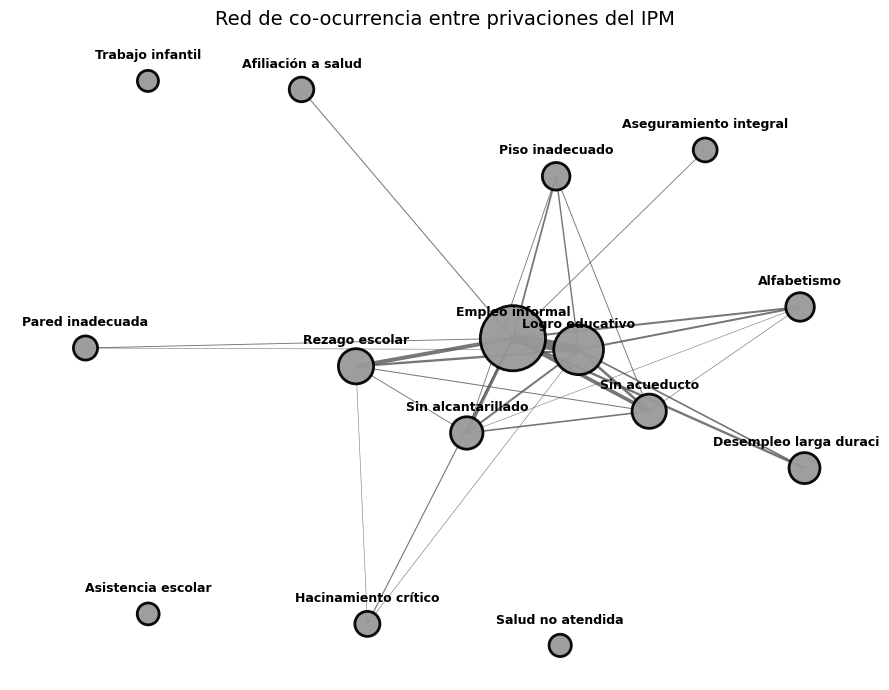

In [ ]:
# ============================================================
# MAPA 3: Red de co-ocurrencia entre privaciones (VERSIÓN OSCURA)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

plt.style.use("default")

# -------------------------
# 0. Diccionario de nombres bonitos
# -------------------------
nombre_priv = {
    "LOGRO_2":        "Logro educativo",
    "ALFA_2":         "Alfabetismo",
    "ASISTE_2":       "Asistencia escolar",
    "REZAGO_2":       "Rezago escolar",
    "A_INTEGRAL_2":   "Aseguramiento integral",
    "TRABAJOINF_2":   "Trabajo infantil",
    "DES_DURA_2":     "Desempleo larga duración",
    "EFORMAL_2":      "Empleo informal",
    "SEGURO_SALUD_2": "Afiliación a salud",
    "SALUD_NEC_2":    "Salud no atendida",
    "ACUEDUCTO":      "Sin acueducto",
    "ALCANTARILLADO": "Sin alcantarillado",
    "PISOS":          "Piso inadecuado",
    "PAREDES":        "Pared inadecuada",
    "HACINAMIENTO":   "Hacinamiento crítico"
}

# 1. Matriz de privaciones binaria
X_priv = df[privaciones_cols].values.astype(float)
n_hogares = X_priv.shape[0]
n_vars = len(privaciones_cols)

# 2. Prevalencia y co-ocurrencia
p1 = X_priv.mean(axis=0)
cooc = (X_priv.T @ X_priv) / n_hogares

# 3. Construir grafo con umbral
umbral_cooc = np.quantile(cooc[np.triu_indices(n_vars, k=1)], 0.75)

G = nx.Graph()
for i, var in enumerate(privaciones_cols):
    G.add_node(var, prevalence=p1[i])

for i in range(n_vars):
    for j in range(i + 1, n_vars):
        if cooc[i, j] >= umbral_cooc:
            G.add_edge(privaciones_cols[i], privaciones_cols[j], weight=cooc[i, j])

# 4. MISMO layout (spring)
pos = nx.spring_layout(G, seed=42, weight="weight", k=0.6)

# Tamaño nodos
prev = np.array([G.nodes[v]["prevalence"] for v in G.nodes()])
sizes_plot = 2000 * (prev / prev.max()) + 200

# Ancho aristas
weights = np.array([G[u][v]["weight"] for u, v in G.edges()])
widths_plot =  7 * (weights / weights.max())

# -------------------------
# 5. Dibujar (estilo oscuro)
# -------------------------
fig, ax = plt.subplots(figsize=(9, 7))

# Aristas gris oscuro
nx.draw_networkx_edges(
    G, pos, ax=ax,
    width=widths_plot,
    alpha=0.8,
    edge_color="#555555"   # gris oscuro
)

# Nodos gris oscuro con borde negro
nx.draw_networkx_nodes(
    G, pos, ax=ax,
    node_size=sizes_plot,
    node_color="#999999",   # gris medio
    edgecolors= "black",
    linewidths=2,
    alpha=0.95
)

# Etiquetas con nombres completos
labels_final = {v: nombre_priv.get(v, v) for v in G.nodes()}

# --- Mover etiquetas ARRIBA del nodo ---
pos_labels = {}

for node, (x, y) in pos.items():
    pos_labels[node] = (x, y + 0.08)   # <- ajusta 0.08 si quieres más arriba

nx.draw_networkx_labels(
    G,
    pos_labels,
    ax=ax,
    labels=labels_final,  # usa tus nombres
    font_size=9,
    font_weight="bold"
)

ax.set_title("Red de co-ocurrencia entre privaciones del IPM", fontsize=14)
ax.axis("off")

fig.tight_layout()
fig.savefig("mapa3_red_privaciones_oscuras.png", dpi=300, bbox_inches="tight")
print("✓ Figura guardada: mapa3_red_privaciones_oscuras.png")

plt.show()
plt.close(fig)


In [ ]:
df_cluster = df.copy()       # la base con 53.103 filas
df_cluster["cluster"] = cluster_labels


In [ ]:
dom_cluster = (
    df_cluster
    .groupby(["DEPARTAMENTO", "cluster"])
    .size()
    .reset_index(name="n")
    .sort_values(["DEPARTAMENTO", "n"], ascending=[True, False])
    .drop_duplicates("DEPARTAMENTO")             # cluster más frecuente por depto
)


Index(['DPTO_CCDGO', 'DPTO_CNMBR', 'DPTO_NANO_', 'DPTO_CACTO', 'DPTO_NANO',
       'Shape_Leng', 'Shape_Area', 'geometry'],
      dtype='object')


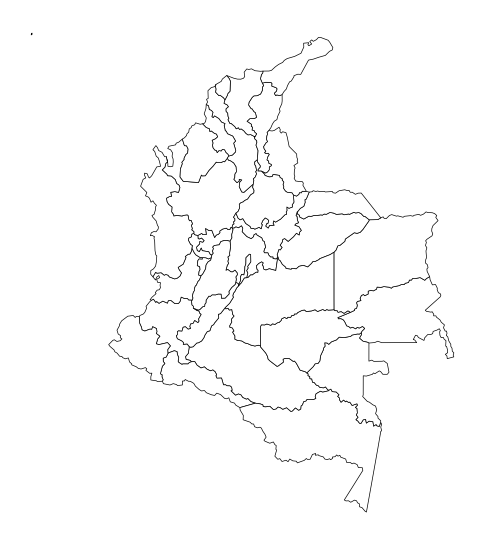

In [ ]:

import geopandas as gpd
import matplotlib.pyplot as plt

# URL DIRECTA AL GEOJSON DE DEPARTAMENTOS
url_deptos = "https://raw.githubusercontent.com/caticoa3/colombia_mapa/master/co_2018_MGN_DPTO_POLITICO.geojson"

# Leer el mapa directamente desde GitHub
gdf = gpd.read_file(url_deptos)

print(gdf.columns)   # para que veas qué columnas trae (nombre depto, código, etc.)

# Probar que el mapa carga bien
fig, ax = plt.subplots(figsize=(6, 8))
gdf.plot(ax=ax, edgecolor="black", facecolor="white", linewidth=0.5)
ax.set_axis_off()
plt.show()



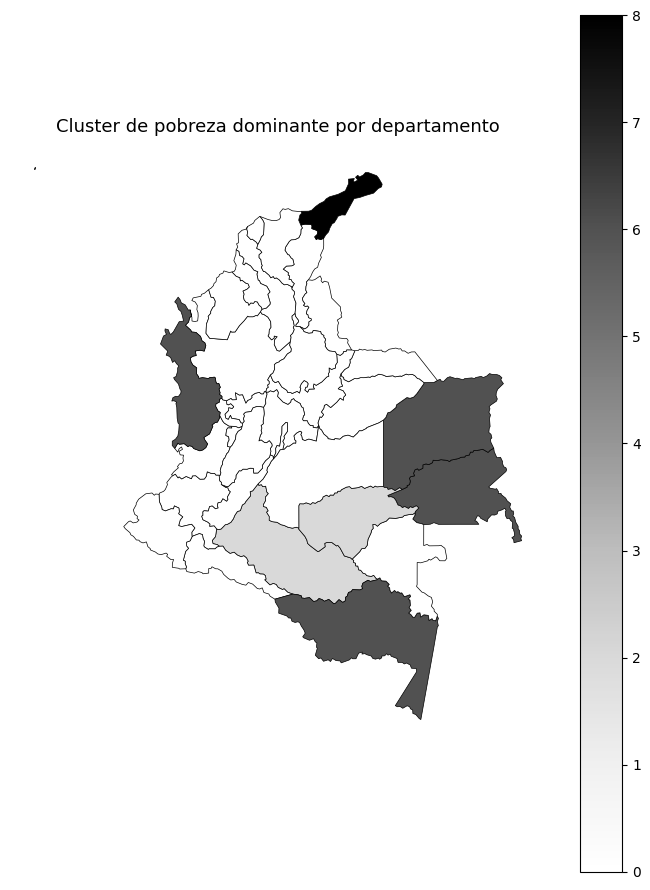

✓ Figura guardada: mapa_clusters_departamentos.png


In [ ]:
# ============================================================
# MAPA: Cluster dominante por departamento (usando el GeoJSON)
# ============================================================

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

plt.style.use("default")

# ------------------------------------------------------------
# 0. Cargar el GeoJSON de departamentos (el mismo que ya usaste)
#    Si ya tienes gdf creado, puedes reutilizarlo y saltar esta parte.
# ------------------------------------------------------------
url_deptos = "https://raw.githubusercontent.com/caticoa3/colombia_mapa/master/co_2018_MGN_DPTO_POLITICO.geojson"
gdf = gpd.read_file(url_deptos)

# ------------------------------------------------------------
# 1. Unir los clusters a la base df (MISMA base con la que hiciste K-Means)
# ------------------------------------------------------------
# Aseguramos que df y cluster_labels correspondan 1 a 1
assert len(df) == len(cluster_labels), "df y cluster_labels no tienen la misma longitud."

df_cluster = df.copy()
df_cluster["cluster"] = cluster_labels

# 👉 CAMBIA 'DEPARTAMENTO' si tu columna de dpto tiene otro nombre
#    La idea es crear una columna 'DPTO_CCDGO' en formato texto de 2 dígitos
df_cluster["DPTO_CCDGO"] = (
    df_cluster["DEPARTAMENTO"]    # <--- aquí cambia el nombre si es distinto
    .astype(int)
    .astype(str)
    .str.zfill(2)
)

# ------------------------------------------------------------
# 2. Cluster dominante por departamento
# ------------------------------------------------------------
dom_cluster = (
    df_cluster
    .groupby(["DPTO_CCDGO", "cluster"])
    .size()
    .reset_index(name="n")
    .sort_values(["DPTO_CCDGO", "n"], ascending=[True, False])
    .drop_duplicates("DPTO_CCDGO")       # se queda con el cluster más frecuente
)

# ------------------------------------------------------------
# 3. Unir el GeoDataFrame con la info de cluster dominante
#    En el GeoJSON el código de dpto viene como 'DPTO_CCDGO'
# ------------------------------------------------------------
gdf_merge = gdf.merge(dom_cluster[["DPTO_CCDGO", "cluster"]],
                      on="DPTO_CCDGO",
                      how="left")

# ------------------------------------------------------------
# 4. Graficar mapa en escala de grises (estilo tesis)
# ------------------------------------------------------------
fig, ax = plt.subplots(figsize=(7, 9))

gdf_merge.plot(
    column="cluster",
    cmap="Greys",          # escala de grises
    linewidth=0.5,
    edgecolor="black",
    legend=True,
    ax=ax
)

ax.set_axis_off()
ax.set_title("Cluster de pobreza dominante por departamento", fontsize=13)

fig.tight_layout()
fig.savefig("mapa_clusters_departamentos.png", dpi=300, bbox_inches="tight")
plt.show()

print("✓ Figura guardada: mapa_clusters_departamentos.png")


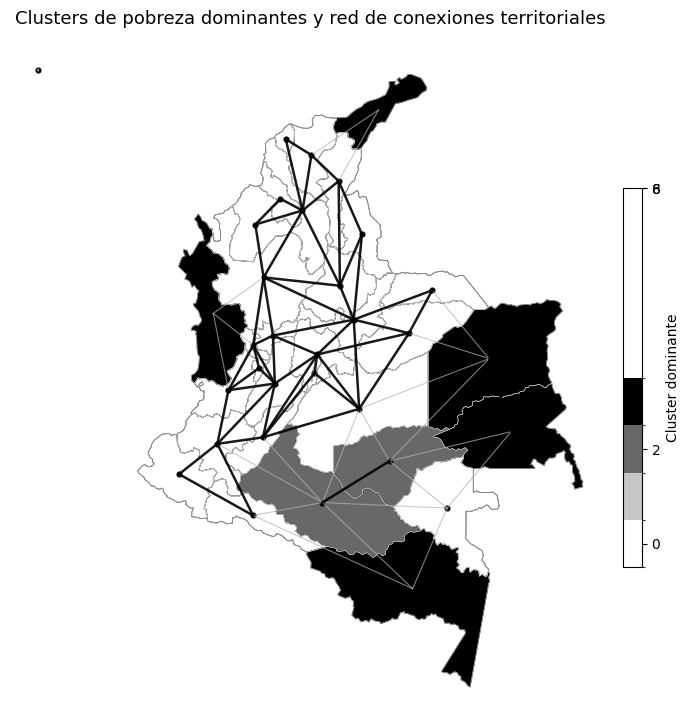

✓ Figura guardada: mapa_clusters_con_explicita_red.png


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# MAPA MEJORADO: MUCHAS CONEXIONES + LÍNEAS OSCURAS
# ============================================================

gdf_merge = gdf_merge.copy()
gdf_merge["centroid"] = gdf_merge.geometry.centroid

# Lista de deptos con cluster definido
depts = gdf_merge.dropna(subset=["cluster"]).reset_index(drop=True)

# Construir listas de conexiones:
# - edges_same: vecinos con mismo cluster
# - edges_diff: vecinos con cluster diferente
edges_same = []
edges_diff = []

for i, row_i in depts.iterrows():
    for j, row_j in depts.iterrows():
        if j <= i:
            continue
        if row_i.geometry.touches(row_j.geometry):
            p_i = (row_i["centroid"].x, row_i["centroid"].y)
            p_j = (row_j["centroid"].x, row_j["centroid"].y)
            if row_i["cluster"] == row_j["cluster"]:
                edges_same.append((p_i, p_j))
            else:
                edges_diff.append((p_i, p_j))

# Paleta discreta en escala de grises para clusters
clusters_unique = np.sort(depts["cluster"].unique())
n_clusters = len(clusters_unique)
cmap = plt.cm.get_cmap("Greys", n_clusters)
bounds = np.arange(-0.5, n_clusters + 0.5, 1)
norm = plt.matplotlib.colors.BoundaryNorm(bounds, n_clusters)

fig, ax = plt.subplots(figsize=(7, 9))

# Base: fronteras en gris claro
gdf_merge.boundary.plot(ax=ax, linewidth=0.4, color="lightgray")

# Relleno: cluster dominante por dpto
depts.plot(
    column="cluster",
    cmap=cmap,
    norm=norm,
    linewidth=0.6,
    edgecolor="black",
    ax=ax,
    legend=False
)

# Conexiones entre vecinos con cluster distinto (muchas líneas claras)
for (x0, y0), (x1, y1) in edges_diff:
    ax.plot([x0, x1], [y0, y1],
            color="0.7",  # gris claro
            linewidth=0.8,
            alpha=0.7)

# Conexiones entre vecinos con mismo cluster (líneas oscuras y gruesas)
for (x0, y0), (x1, y1) in edges_same:
    ax.plot([x0, x1], [y0, y1],
            color="black",
            linewidth=1.8,
            alpha=0.9)

# Centroides como nodos
ax.scatter(
    depts["centroid"].x,
    depts["centroid"].y,
    s=12,
    color="black",
    alpha=0.9
)

# Barra de colores para clusters
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.02)
cbar.set_ticks(clusters_unique)
cbar.set_label("Cluster dominante", fontsize=10)

ax.set_axis_off()
ax.set_title("Clusters de pobreza dominantes y red de conexiones territoriales",
             fontsize=13, pad=10)

fig.tight_layout()
fig.savefig("mapa_clusters_con_explicita_red.png", dpi=300, bbox_inches="tight")
plt.show()

print("✓ Figura guardada: mapa_clusters_con_explicita_red.png")


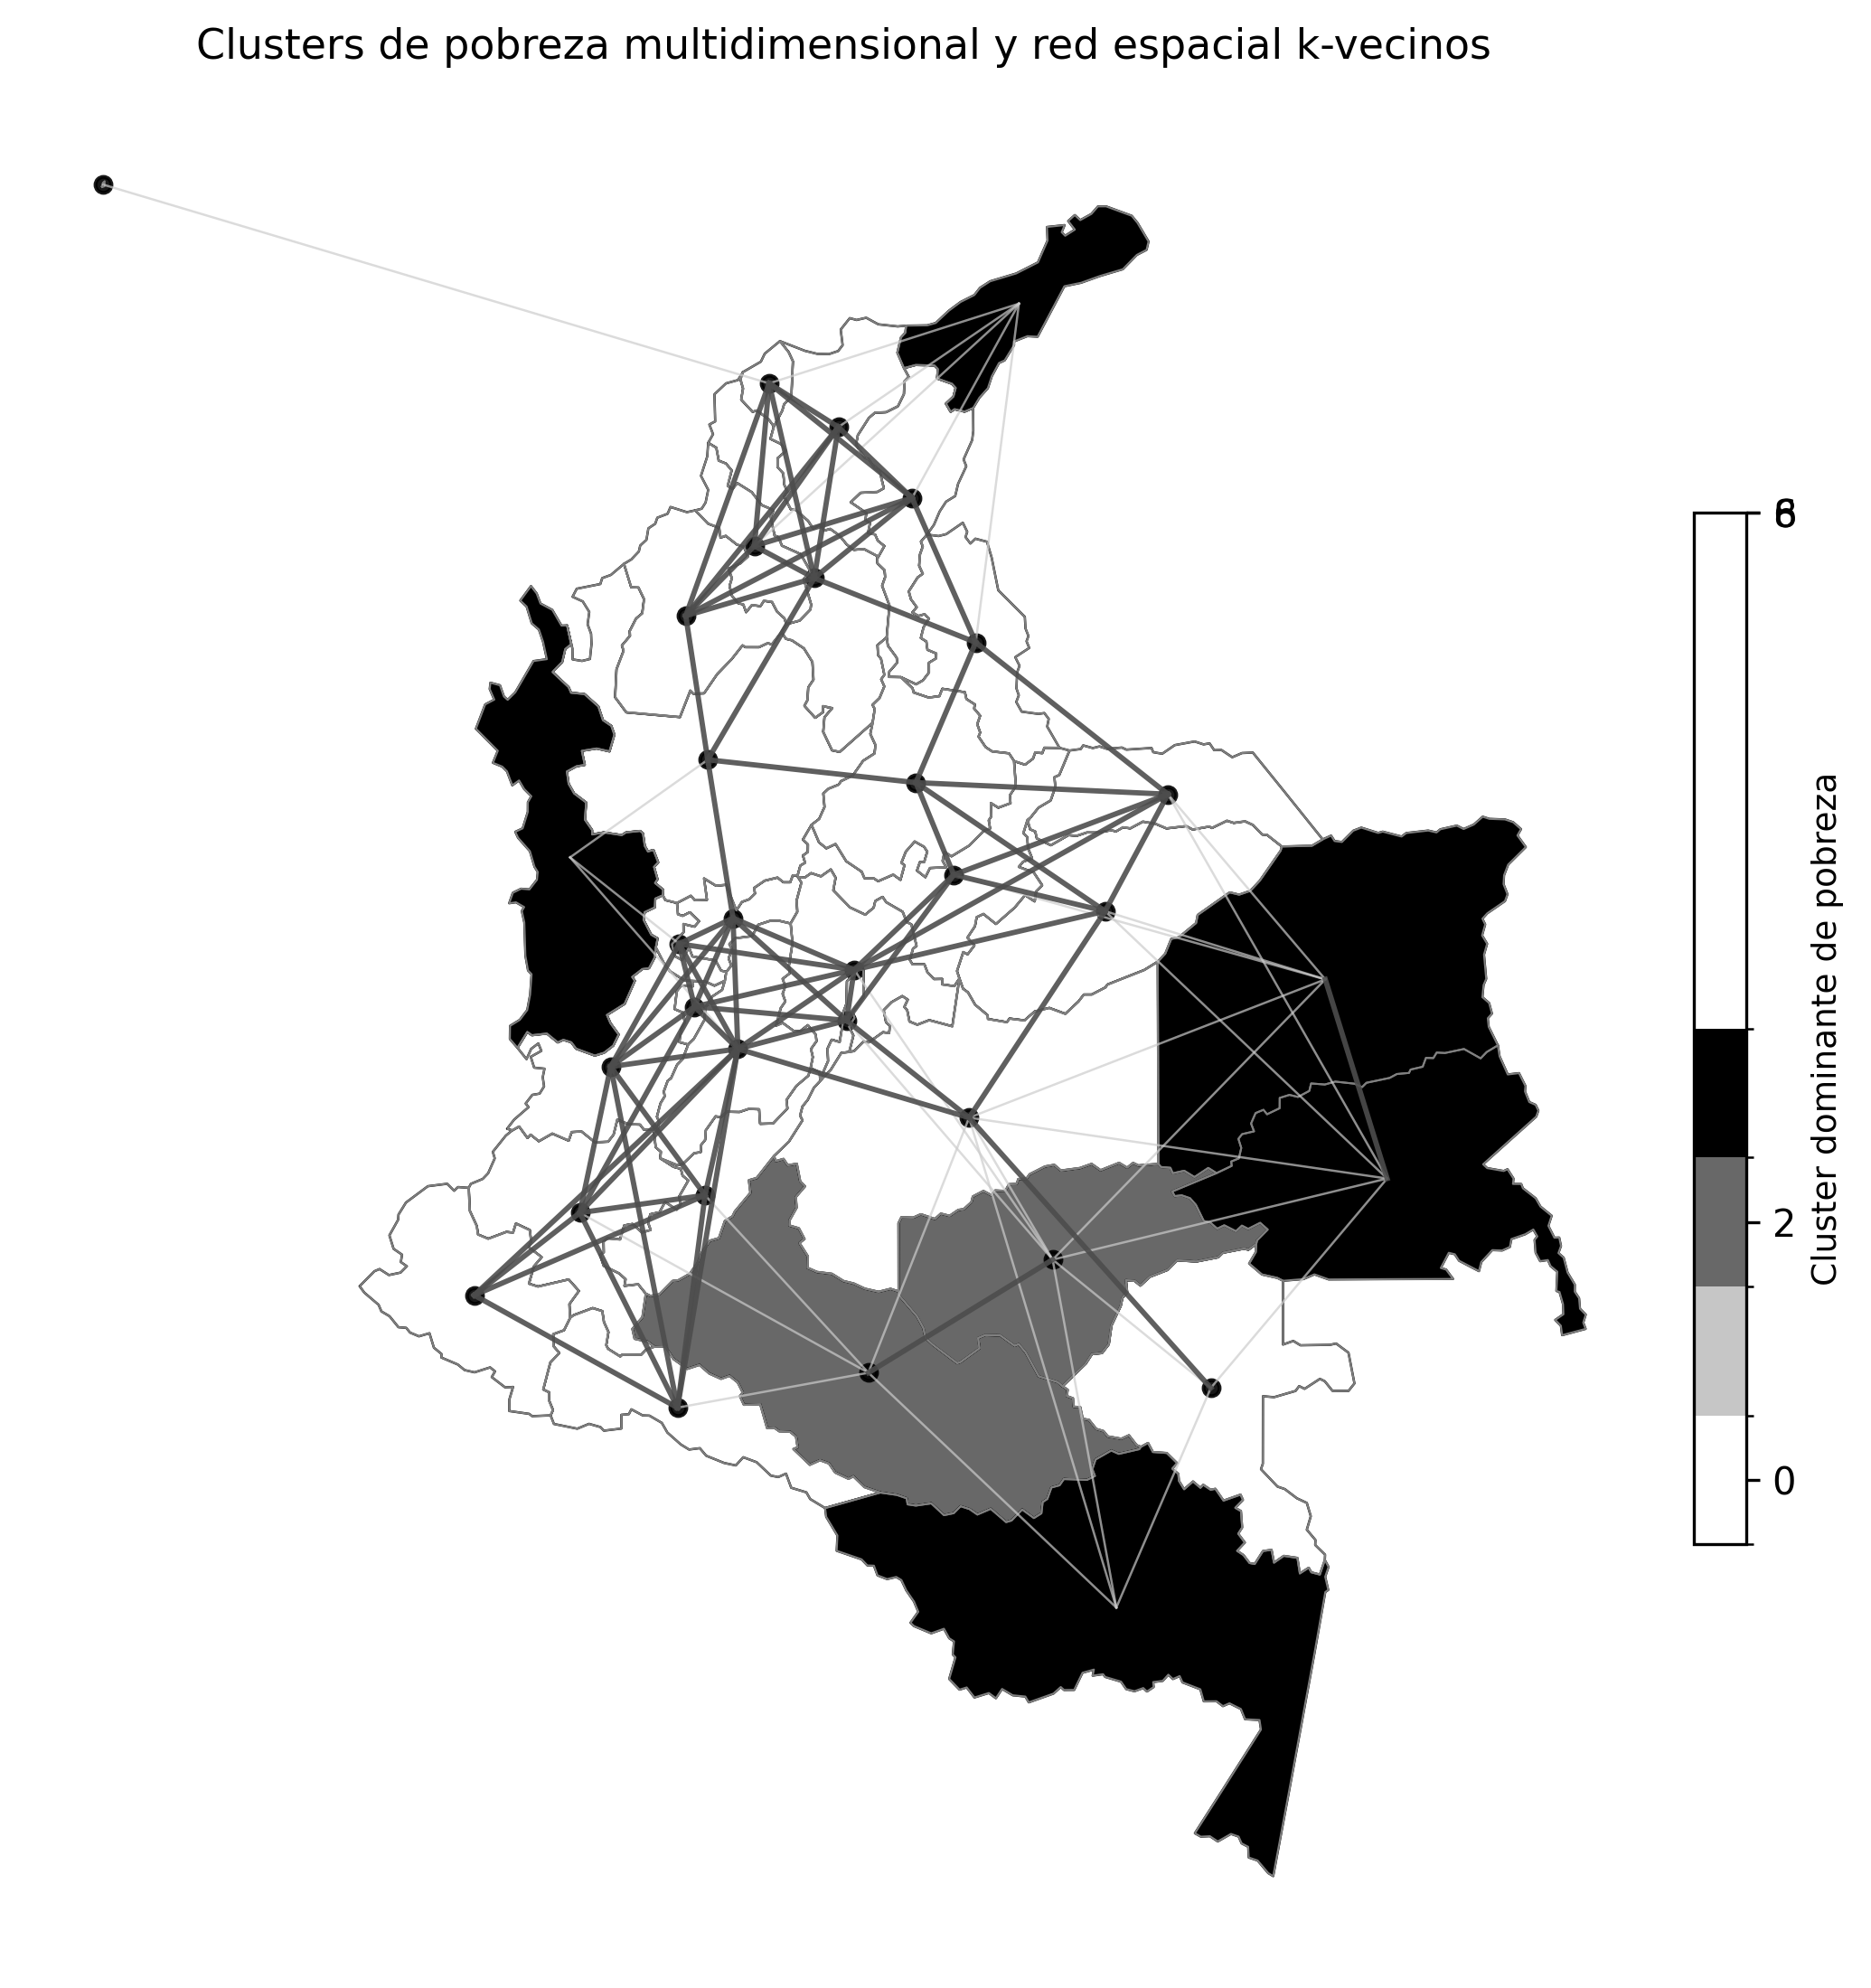

✓ Figura guardada: mapa_clusters_knn_blanco.png


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# ============================================================
# MAPA: CLUSTERS + RED ESPACIAL K-NN (FONDO BLANCO)
# ============================================================

# 1. Reproyectar y centrar en Colombia
gdf_plot = gdf_merge.to_crs(epsg=3116).copy()
gdf_plot["centroid"] = gdf_plot.geometry.centroid

# Solo departamentos con cluster definido
depts = gdf_plot.dropna(subset=["cluster"]).reset_index(drop=True)

# 2. Construir red k-NN sobre centroides (muchas conexiones)
coords = np.vstack([depts["centroid"].x.values,
                    depts["centroid"].y.values]).T

n = coords.shape[0]
k = 6  # número de vecinos por depto (ajusta si quieres aún más)

edges_same = []
edges_diff = []

for i in range(n):
    # Distancia del depto i a todos
    dists = np.sqrt(((coords - coords[i])**2).sum(axis=1))
    idx_sorted = np.argsort(dists)

    # Tomar los k vecinos más cercanos (saltando a sí mismo)
    vecinos = [j for j in idx_sorted if j != i][:k]

    for j in vecinos:
        # Evitar duplicar aristas i-j y j-i
        if j < i:
            continue

        p_i = coords[i]
        p_j = coords[j]

        if depts.loc[i, "cluster"] == depts.loc[j, "cluster"]:
            edges_same.append((p_i, p_j))
        else:
            edges_diff.append((p_i, p_j))

# 3. Paleta discreta en escala de grises para los clusters
clusters_unique = np.sort(depts["cluster"].unique())
n_clusters = len(clusters_unique)

cmap = plt.cm.get_cmap("Greys", n_clusters)
bounds = np.arange(-0.5, n_clusters + 0.5, 1)
norm = mcolors.BoundaryNorm(bounds, n_clusters)

# 4. Dibujar figura
fig, ax = plt.subplots(figsize=(7, 9), dpi=300)
fig.patch.set_facecolor("white")
ax.set_facecolor("white")

# Base: fronteras de todos los departamentos
gdf_plot.boundary.plot(ax=ax, linewidth=0.5, color="gray")

# Relleno por cluster dominante
depts.plot(
    column="cluster",
    cmap=cmap,
    norm=norm,
    linewidth=0.6,
    edgecolor="black",
    ax=ax,
    legend=False
)

# Conexiones entre k vecinos (muchas líneas)
# Diferente intensidad según compartan o no el mismo cluster
for (p_i, p_j) in edges_diff:
    ax.plot([p_i[0], p_j[0]], [p_i[1], p_j[1]],
            color="0.80", linewidth=0.6, alpha=0.7)

for (p_i, p_j) in edges_same:
    ax.plot([p_i[0], p_j[0]], [p_i[1], p_j[1]],
            color="0.30", linewidth=1.4, alpha=0.9)

# Nodos (centroides)
ax.scatter(
    depts["centroid"].x,
    depts["centroid"].y,
    s=18,
    color="black",
    alpha=0.9
)

# Barra de color para clusters
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.02)
cbar.set_ticks(clusters_unique)
cbar.set_label("Cluster dominante de pobreza", fontsize=9)

ax.set_axis_off()
ax.set_title(
    "Clusters de pobreza multidimensional y red espacial k-vecinos",
    fontsize=11,
    pad=10
)

fig.tight_layout()
fig.savefig("mapa_clusters_knn_blanco.png", dpi=300, bbox_inches="tight")
plt.show()

print("✓ Figura guardada: mapa_clusters_knn_blanco.png")


In [70]:
# ============================================================
# MAPA TIPO ISOYETAS A PARTIR DE LOS CLUSTERS POR DEPARTAMENTO
# ============================================================

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from scipy.interpolate import griddata
import matplotlib.colors as mcolors

plt.style.use("default")



In [ ]:

# ------------------------------------------------------------
# 0. Partimos de gdf_merge (deptos + 'cluster')
# ------------------------------------------------------------
# Reproyectar a un CRS métrico para trabajar en metros (Colombia)
gdf_iso = gdf_merge.to_crs(epsg=3116).copy()

# Elegimos la variable continua a interpolar.
# En tu caso usaré el número de cluster; si luego tienes IPM continuo,
# basta con cambiar 'cluster' por el nombre de esa columna.
var_col = "cluster"

# ------------------------------------------------------------
# 1. Generar muchos puntos aleatorios dentro de cada departamento
# ------------------------------------------------------------

def sample_points_in_polygon(poly, n_points, value):
    """Genera n_points puntos aleatorios dentro de un polígono,
    todos con el mismo valor (cluster o IPM)."""
    minx, miny, maxx, maxy = poly.bounds
    pts = []
    vals = []
    count = 0
    # rechazo simple hasta completar n_points
    while count < n_points:
        x = np.random.uniform(minx, maxx)
        y = np.random.uniform(miny, maxy)
        p = Point(x, y)
        if poly.contains(p):
            pts.append((x, y))
            vals.append(value)
            count += 1
    return pts, vals

# número de puntos por departamento (ajusta: más puntos = mapa más suave pero más pesado)
n_points_per_dept = 300

all_pts = []
all_vals = []

for _, row in gdf_iso.dropna(subset=[var_col]).iterrows():
    poly = row.geometry
    val = row[var_col]
    pts, vals = sample_points_in_polygon(poly, n_points_per_dept, val)
    all_pts.extend(pts)
    all_vals.extend(vals)

all_pts = np.array(all_pts)      # shape (N, 2)
all_vals = np.array(all_vals)    # shape (N,)

print(f"Puntos generados para interpolación: {all_pts.shape[0]}")

# ------------------------------------------------------------
# 2. Crear una malla regular sobre Colombia y hacer interpolación
# ------------------------------------------------------------
xmin, ymin, xmax, ymax = gdf_iso.total_bounds

# resolución de la malla (ajusta si quieres más detalle)
nx, ny = 250, 250
grid_x, grid_y = np.meshgrid(
    np.linspace(xmin, xmax, nx),
    np.linspace(ymin, ymax, ny)
)

# Interpolación (linear). Si hay problemas, puedes probar "cubic" o "nearest".
grid_z = griddata(
    points=all_pts,
    values=all_vals,
    xi=(grid_x, grid_y),
    method="linear"
)

# Opcional: enmascarar fuera de Colombia (para que no pinte el mar)
# Creamos una máscara booleana: True si el centro de la celda está dentro de algún polígono
from shapely.geometry import Point

mask = np.zeros_like(grid_z, dtype=bool)
for i in range(nx):
    for j in range(ny):
        p = Point(grid_x[j, i], grid_y[j, i])
        if gdf_iso.geometry.unary_union.contains(p):
            mask[j, i] = True
        else:
            mask[j, i] = False

grid_z_masked = np.where(mask, grid_z, np.nan)


Puntos generados para interpolación: 9900


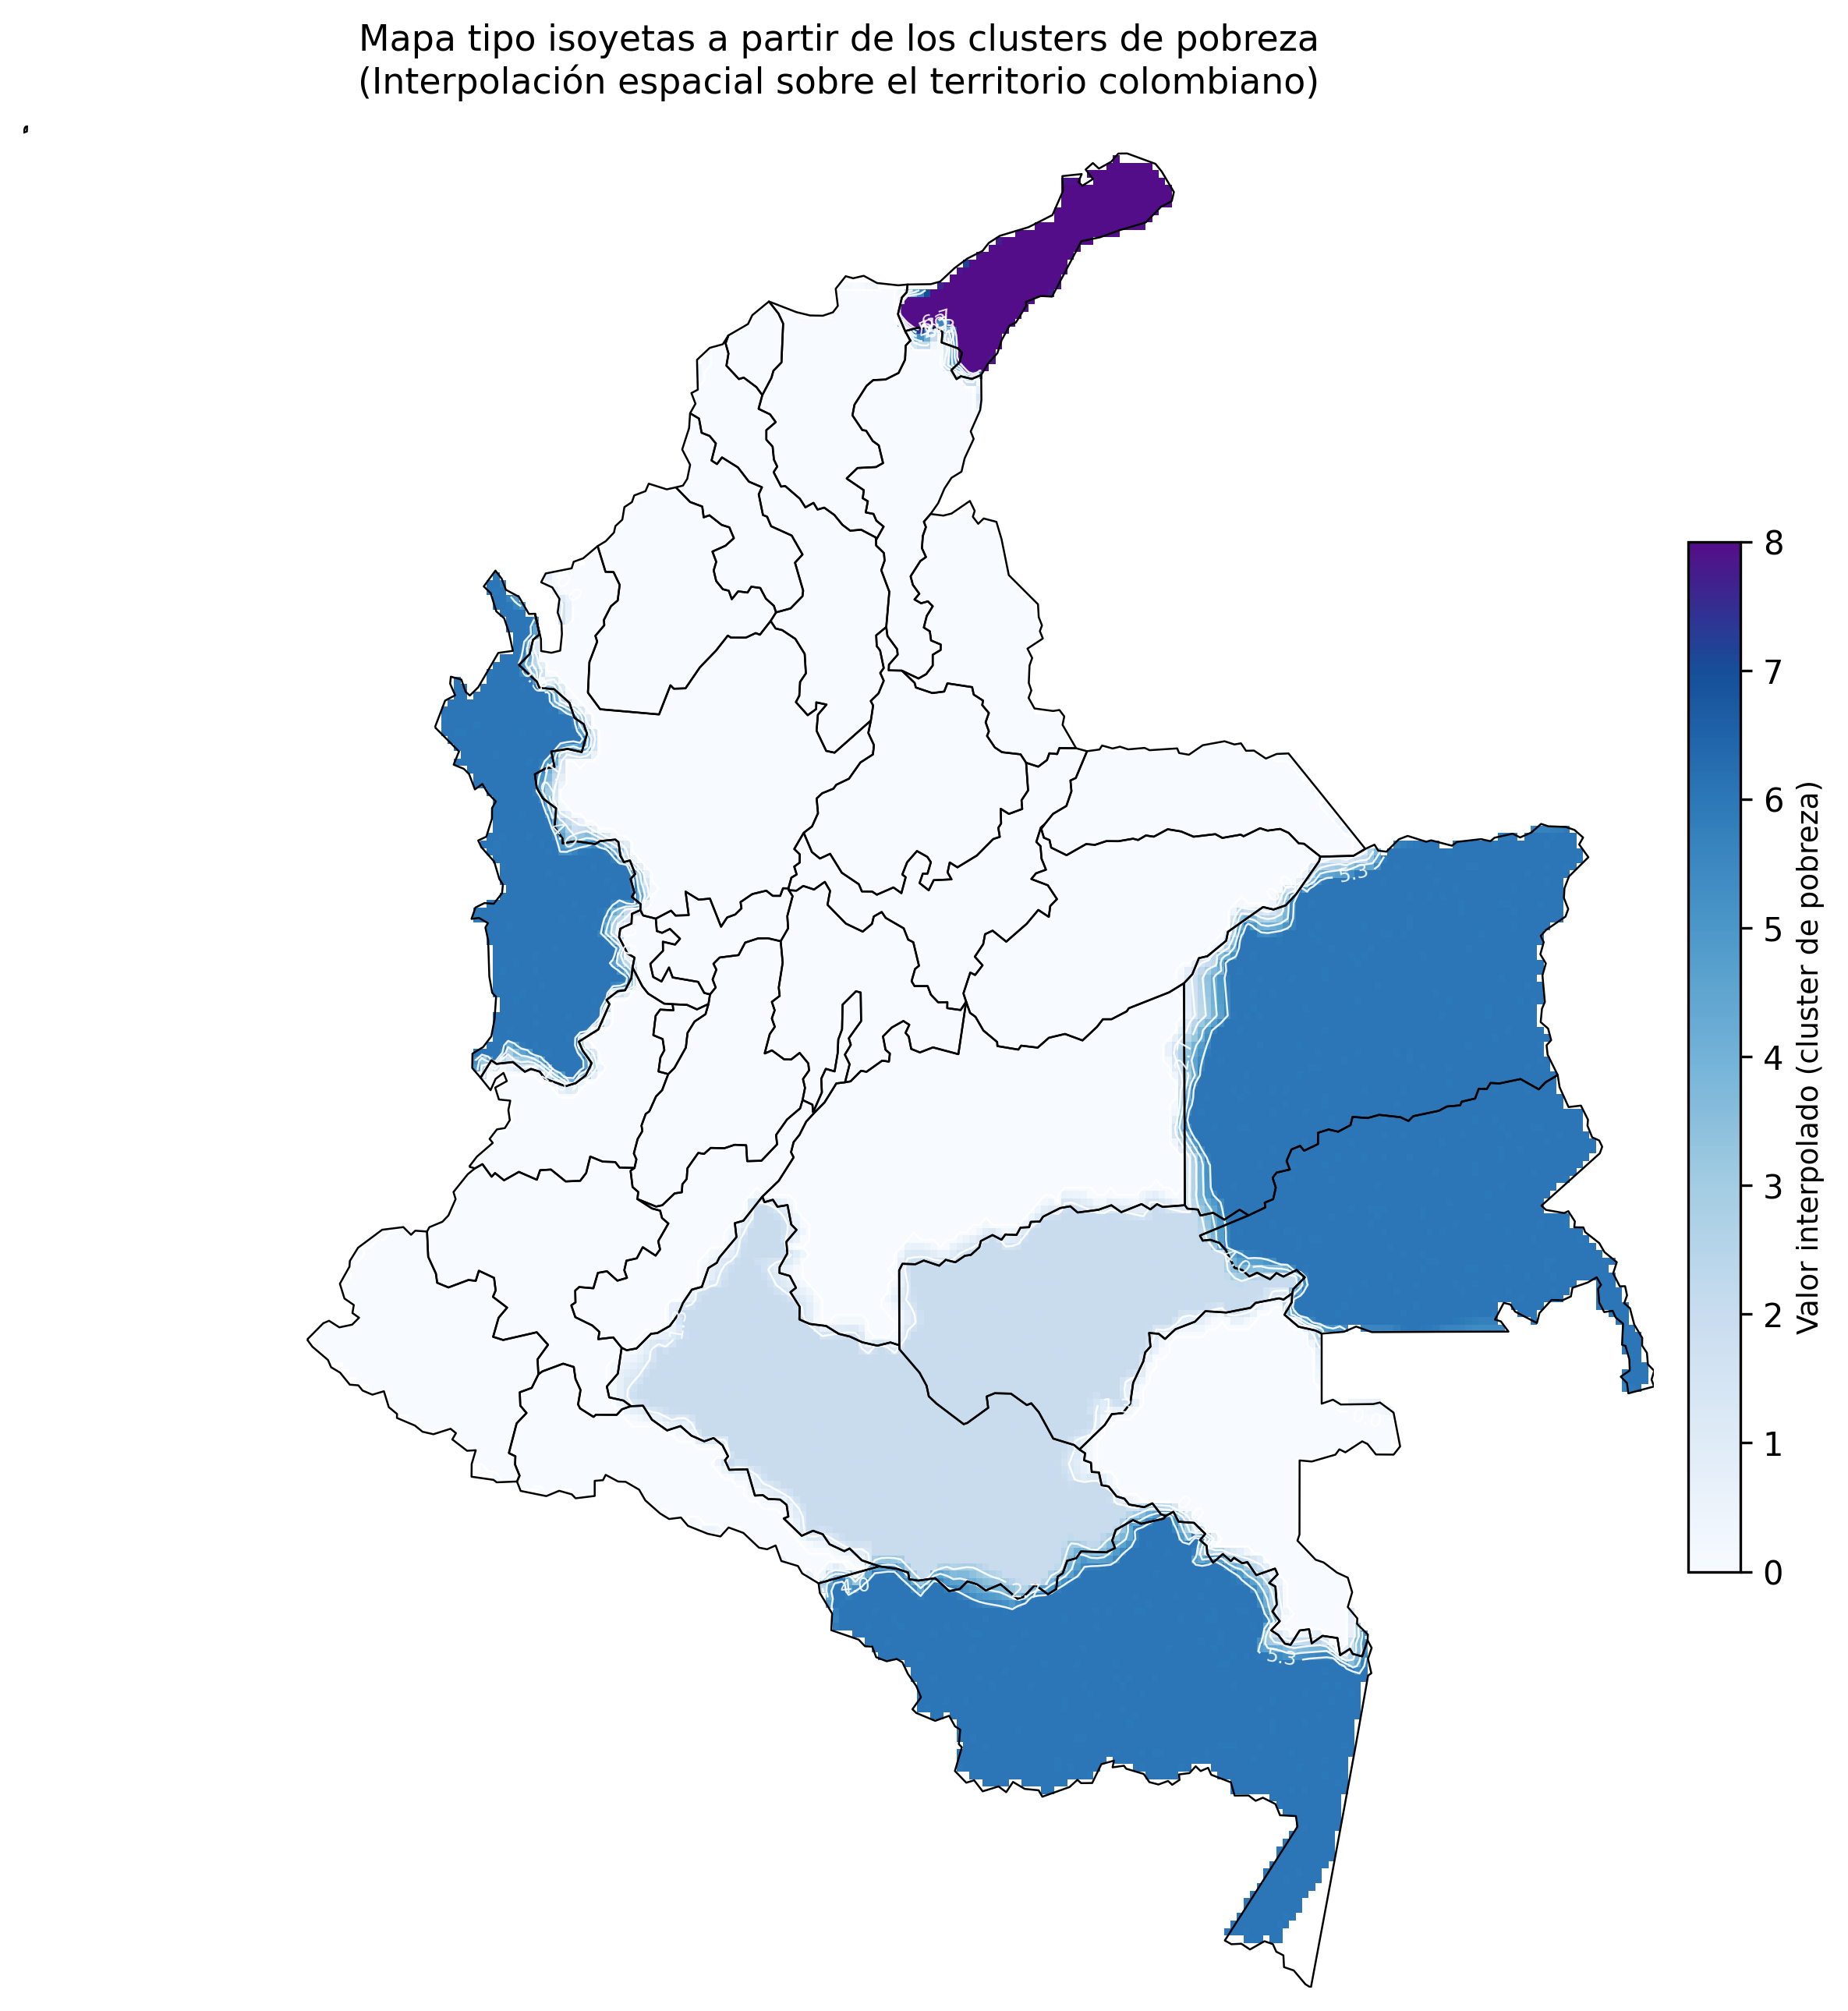

✓ Figura guardada: mapa_clusters_isoyetas.png


In [ ]:

# ------------------------------------------------------------
# 3. Definir paleta tipo España (azules a morado)
# ------------------------------------------------------------
# Paleta personalizada aproximando el estilo de la imagen de España
colors = ["#f7fbff", "#deebf7", "#c6dbef", "#9ecae1",
          "#6baed6", "#4292c6", "#2171b5", "#084594", "#4b0082"]
cmap_iso = mcolors.LinearSegmentedColormap.from_list("ipm_iso", colors)

# Definimos niveles (contornos) en función de los valores del grid
vmin = np.nanmin(grid_z_masked)
vmax = np.nanmax(grid_z_masked)
n_levels = 7
levels = np.linspace(vmin, vmax, n_levels)

# ------------------------------------------------------------
# 4. Dibujar el mapa tipo isoyetas
# ------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 10), dpi=300)

# Fondo blanco
fig.patch.set_facecolor("white")
ax.set_facecolor("white")

# 4a. Campo interpolado (como raster)
im = ax.imshow(
    grid_z_masked,
    extent=(xmin, xmax, ymin, ymax),
    origin="lower",
    cmap=cmap_iso,
    vmin=vmin,
    vmax=vmax,
    alpha=0.95
)

# 4b. Isocurvas (contornos) en blanco
cs = ax.contour(
    grid_x, grid_y, grid_z_masked,
    levels=levels,
    colors="white",
    linewidths=0.6,
    alpha=0.9
)

# Opcional: etiquetas numéricas sobre algunas curvas
ax.clabel(cs, inline=True, fontsize=6, fmt="%.1f")

# 4c. Bordes departamentales encima, en gris oscuro
gdf_iso.boundary.plot(ax=ax, edgecolor="black", linewidth=0.6)

# ------------------------------------------------------------
# 5. Leyenda / barra de color
# ------------------------------------------------------------
cbar = fig.colorbar(im, ax=ax, fraction=0.03, pad=0.02)
cbar.set_label("Valor interpolado (cluster de pobreza)", fontsize=9)

ax.set_axis_off()
ax.set_title(
    "Mapa tipo isoyetas a partir de los clusters de pobreza\n(Interpolación espacial sobre el territorio colombiano)",
    fontsize=11,
    pad=10
)

fig.tight_layout()
fig.savefig("mapa_clusters_isoyetas.png", dpi=300, bbox_inches="tight")
plt.show()

print("✓ Figura guardada: mapa_clusters_isoyetas.png")

## CONCLUSIONES

### Hallazgos principales:
1. Se identificaron perfiles diferenciados de hogares según sus privaciones
2. Los clusters muestran coherencia con el IPM oficial
3. Existe heterogeneidad territorial significativa

### Próximos pasos:
1. Usar clusters como variable en modelos predictivos (XGBoost)
2. Validar perfiles con expertos en política social
3. Diseñar intervenciones diferenciadas por perfil